In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import timedelta
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [2]:
model = pkl.load(open('XGBoostBP.pkl', 'rb'))
model

XGBRegressor(alpha=0.015070370770080777, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7923341190026657, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.03445658082554569,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.00842590842203368,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=841, n_jobs=None,
             num_parallel_tree=None, ...)

In [3]:
#Import the data for the optimization
df_Opti_Data = pd.read_csv('Data_Demo.csv')
df_Opti_Data.set_index('Datetime', inplace=True, drop=True)


In [4]:
df_Forecast_Data = pd.read_csv('dataPowerForecast.csv')
df_Forecast_Data.set_index('Unnamed: 0', inplace=True)
df_Forecast_Data.index.name = 'Datetime'
df_Forecast_Data

,Power Demand,temperature_2m (°C),month,day,hour,day_of_week,is_closed_holiday,is_open_holiday,hour_sin,hour_cos,...,lag_45,lag_46,lag_47,lag_48,Hist3,Hist4,Hist5,Hist6,Hist7,Hist14
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-17 07:00:00,349.97000,8.1,1,17,7,0,0,0,0.965926,-0.258819,...,1078.653,485.105,344.400,343.373,360.020,378.134,380.620,357.754,364.758,362.855
2022-01-17 08:00:00,394.61400,8.4,1,17,8,0,0,0,0.866025,-0.500000,...,876.306,1078.653,485.105,344.400,418.227,407.370,432.543,387.589,515.138,364.154
2022-01-17 09:00:00,486.93400,8.3,1,17,9,0,0,0,0.707107,-0.707107,...,992.110,876.306,1078.653,485.105,484.514,500.156,536.122,487.419,508.573,643.695
2022-01-17 10:00:00,795.35200,8.6,1,17,10,0,0,0,0.500000,-0.866025,...,1191.000,992.110,876.306,1078.653,795.425,798.504,824.700,820.998,846.925,1127.542
2022-01-17 11:00:00,806.46100,10.3,1,17,11,0,0,0,0.258819,-0.965926,...,826.301,1191.000,992.110,876.306,816.016,813.639,832.711,835.816,841.541,1075.544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,386.40200,10.3,12,31,19,6,0,0,-0.965926,0.258819,...,513.495,888.705,827.277,870.664,948.679,674.813,719.024,168.419,249.957,738.243
2023-12-31 20:00:00,274.70842,9.5,12,31,20,6,0,0,-0.866025,0.500000,...,396.819,513.495,888.705,827.277,798.817,789.435,701.121,162.442,178.198,852.652
2023-12-31 21:00:00,173.46673,8.5,12,31,21,6,0,0,-0.707107,0.707107,...,218.730,396.819,513.495,888.705,868.604,765.233,664.890,161.401,168.203,869.045


In [5]:
def dataframe_date(df,date):

    end_date = pd.to_datetime(date) + timedelta(days=3)
    end_date = end_date.strftime('%Y-%m-%d')

    df = df.reset_index()
    
    mask_data = (df['Datetime'] >= date) & (df['Datetime'] <= end_date)
    df = df.loc[mask_data]

    df = df.set_index('Datetime', drop=True)

    return df

df_Forecast_Data = dataframe_date(df_Forecast_Data,'2023-06-01')
df_Forecast_Data


,Power Demand,temperature_2m (°C),month,day,hour,day_of_week,is_closed_holiday,is_open_holiday,hour_sin,hour_cos,...,lag_45,lag_46,lag_47,lag_48,Hist3,Hist4,Hist5,Hist6,Hist7,Hist14
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00,271.907,14.1,6,1,0,3,0,0,0.000000,1.000000,...,209.105,244.413,254.233,256.498,285.928,302.80300,265.10300,266.74167,244.98500,266.787
2023-06-01 01:00:00,246.590,15.8,6,1,1,3,0,0,0.258819,0.965926,...,189.548,209.105,244.413,254.233,249.670,275.17700,243.33200,254.70033,240.05100,266.221
2023-06-01 02:00:00,246.793,15.2,6,1,2,3,0,0,0.500000,0.866025,...,205.159,189.548,209.105,244.413,246.456,273.06200,239.19100,247.95100,246.28500,239.022
2023-06-01 03:00:00,215.676,15.2,6,1,3,3,0,0,0.707107,0.707107,...,208.641,205.159,189.548,209.105,216.707,210.84700,209.25800,222.68000,217.35600,227.201
2023-06-01 04:00:00,197.038,15.0,6,1,4,3,0,0,0.866025,0.500000,...,187.860,208.641,205.159,189.548,203.623,193.82100,191.35100,195.69700,190.12800,209.404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-03 19:00:00,1717.618,18.2,6,3,19,5,0,0,-0.965926,0.258819,...,684.640,743.595,786.801,730.125,719.337,741.82900,793.00900,1658.17200,1638.10300,1595.569
2023-06-03 20:00:00,1718.877,17.4,6,3,20,5,0,0,-0.866025,0.500000,...,500.916,684.640,743.595,786.801,747.212,780.83900,797.63000,1654.97400,1639.43067,1512.969
2023-06-03 21:00:00,1457.777,16.5,6,3,21,5,0,0,-0.707107,0.707107,...,259.709,500.916,684.640,743.595,741.061,771.56400,748.75600,1542.76700,1660.39433,1514.213


In [6]:
X_Real = df_Forecast_Data.drop(columns=['Power Demand'])
Y_Real = df_Forecast_Data['Power Demand']
scaler = RobustScaler()
X_Real = scaler.fit_transform(X_Real)

In [7]:
#Y_Real = df_Forecast_Data['Power Demand']
#X_Real = df_Forecast_Data.drop('Power Demand', axis=1)


In [8]:
Y_Real

Datetime
2023-06-01 00:00:00     271.907
2023-06-01 01:00:00     246.590
2023-06-01 02:00:00     246.793
2023-06-01 03:00:00     215.676
2023-06-01 04:00:00     197.038
                         ...   
2023-06-03 19:00:00    1717.618
2023-06-03 20:00:00    1718.877
2023-06-03 21:00:00    1457.777
2023-06-03 22:00:00    1020.936
2023-06-03 23:00:00     514.416
Name: Power Demand, Length: 72, dtype: float64

In [9]:
X_Real

array([[-0.66666667,  0.        , -0.5       , ..., -0.33290785,
        -0.47786741, -0.61751677],
       [-0.26190476,  0.        , -0.5       , ..., -0.34193972,
        -0.48325419, -0.61835723],
       [-0.4047619 ,  0.        , -0.5       , ..., -0.3470022 ,
        -0.47644811, -0.65874519],
       ...,
       [-0.0952381 ,  0.        ,  0.5       , ...,  0.62420237,
         1.06743123,  1.23479373],
       [-0.23809524,  0.        ,  0.5       , ...,  0.20459438,
         0.39380345,  0.32508827],
       [-0.47619048,  0.        ,  0.5       , ..., -0.15896528,
        -0.1901374 , -0.26522131]])

In [10]:
Y_Pred = model.predict(X_Real)
Y_Pred

array([ 250.07767,  236.18614,  234.3543 ,  221.16135,  214.10956,
        212.97223,  226.65355,  226.03882,  229.91924,  327.3527 ,
        841.22986, 1099.8188 , 1267.0416 , 1099.145  , 1115.3138 ,
       1161.1721 , 1153.3413 , 1065.9532 , 1021.9213 ,  834.73517,
        813.9921 ,  763.65497,  662.5152 ,  476.05716,  253.05717,
        236.9923 ,  233.39447,  225.83667,  210.4997 ,  216.2662 ,
        221.56201,  219.97818,  232.90782,  330.09393,  934.63806,
       1145.8308 , 1155.8304 , 1269.5453 , 1270.9641 , 1154.3416 ,
       1151.1667 , 1174.2268 , 1148.7915 ,  794.345  ,  788.1854 ,
        711.9525 ,  671.51953,  466.13065,  245.01404,  234.1672 ,
        234.44221,  221.0024 ,  212.94858,  213.04187,  218.77882,
        216.72469,  226.86133,  356.60217, 1182.1854 , 1416.3605 ,
       1365.0878 , 1464.2452 , 1702.654  , 1673.5612 , 1782.1095 ,
       1745.6953 , 1680.2062 , 1499.4598 , 1469.6891 , 1375.1477 ,
       1012.47003,  487.37387], dtype=float32)

In [11]:
data_graph = pd.DataFrame({'Real': Y_Real, 'Predicted': Y_Pred})
data_graph

,Real,Predicted
Datetime,,
2023-06-01 00:00:00,271.907,250.077667
2023-06-01 01:00:00,246.590,236.186142
2023-06-01 02:00:00,246.793,234.354294
2023-06-01 03:00:00,215.676,221.161346
2023-06-01 04:00:00,197.038,214.109558
...,...,...
2023-06-03 19:00:00,1717.618,1499.459839
2023-06-03 20:00:00,1718.877,1469.689087
2023-06-03 21:00:00,1457.777,1375.147705


c:\Users\tomas.m.santos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tomas.m.santos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Datetime'>

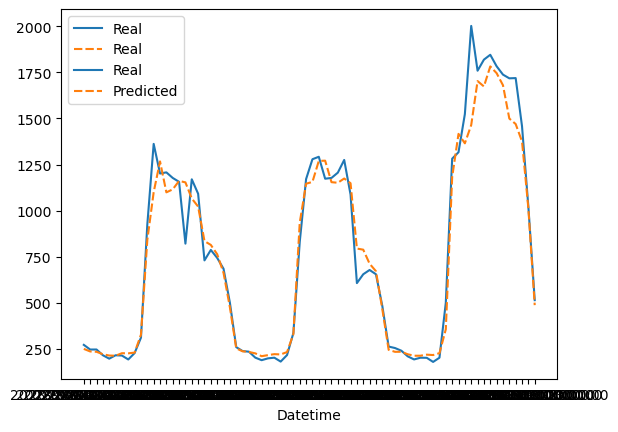

In [12]:
sns.lineplot(data=data_graph, label='Real')

In [13]:
df_Opti_Data= dataframe_date(df_Opti_Data,'2023-06-01')

In [14]:
df_Opti_Data['Electric Power (kW)'] = data_graph['Predicted'].values
df_Opti_Data['Thermal Power (kW)'] = np.zeros(len(df_Opti_Data))
df_Opti_Data


,Electric Power (kW),Thermal Power (kW),Irradiance (W/m2),Cost (Eur/kW),Access Tariff (Eur/kWh),PHP Tariff (Eur/kWh)
Datetime,,,,,,
2023-06-01 00:00:00+00:00,250.077667,0.0,0.000000,0.09409,0.0099,0.000000
2023-06-01 01:00:00+00:00,236.186142,0.0,0.000000,0.08700,0.0078,0.000000
2023-06-01 02:00:00+00:00,234.354294,0.0,0.000000,0.08700,0.0078,0.000000
2023-06-01 03:00:00+00:00,221.161346,0.0,0.000000,0.08901,0.0078,0.000000
2023-06-01 04:00:00+00:00,214.109558,0.0,0.000000,0.08100,0.0078,0.000000
...,...,...,...,...,...,...
2023-06-03 19:00:00+00:00,1499.459839,0.0,139.208130,0.08010,0.0099,0.000000
2023-06-03 20:00:00+00:00,1469.689087,0.0,33.334572,0.08110,0.0099,0.000000
2023-06-03 21:00:00+00:00,1375.147705,0.0,0.000000,0.10200,0.0099,0.000000


In [19]:
df_solar = pd.read_csv('DNI.csv', index_col=0)
#df_Forecast_Data.set_index('time', inplace=True)
df_solar

,Actual DNI,Predicted DNI
time,,
2024-11-20 00:00:00,0.0,0.0
2024-11-20 01:00:00,0.0,0.0
2024-11-20 02:00:00,0.0,0.0
2024-11-20 03:00:00,0.0,0.0
2024-11-20 04:00:00,0.0,0.0
...,...,...
2025-02-18 20:00:00,0.0,0.0
2025-02-18 21:00:00,0.0,0.0
2025-02-18 22:00:00,0.0,0.0
